<a href="https://colab.research.google.com/github/Goldyboi04/Explainable-Loan-Approval-Decision-System/blob/main/notebooks/Explainable_Loan_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Problem Statement

The objective of this project is to design a transparent loan approval decision system
that balances predictive performance, interpretability, and fairness.

The focus is not only on predicting loan approval outcomes, but also on understanding
and explaining the factors influencing these decisions.


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import shap


# 2. Data Preprocessing

In [39]:
df = pd.read_csv("loan_approval_dataset.csv")
df=df.drop(columns=["loan_id"])

In [40]:
df["loan_status"] = df["loan_status"].map({
    " Approved": 1,
    " Rejected": 0
})

In [41]:
df["loan_status"].value_counts()

,count
loan_status,
1,2656
0,1613


In [42]:
df.isnull().sum()

,0
no_of_dependents,0
education,0
self_employed,0
income_annum,0
loan_amount,0
loan_term,0
cibil_score,0
residential_assets_value,0
commercial_assets_value,0
luxury_assets_value,0


In [43]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

OneHotEncoder

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ]
)

# 3. Logistic Regression Pipeline

In [46]:
log_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   ' commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['education',
                                                   'self_employed'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [47]:
y_pred = log_pipeline.predict(X_test)
y_prob = log_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.914519906323185
Precision: 0.9209558823529411
Recall: 0.943502824858757
ROC-AUC: 0.9725501857002093


In [48]:
X_train_transformed = log_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_transformed = log_pipeline.named_steps["preprocessor"].transform(X_test)

In [49]:
ohe = log_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_cols)

feature_names = np.concatenate([numerical_cols, ohe_features])

# 4. SHAP Analysis

In [50]:
explainer = shap.LinearExplainer(
    log_pipeline.named_steps["classifier"],
    X_train_transformed
)

shap_values = explainer.shap_values(X_test_transformed)

4.1 Global Explainability

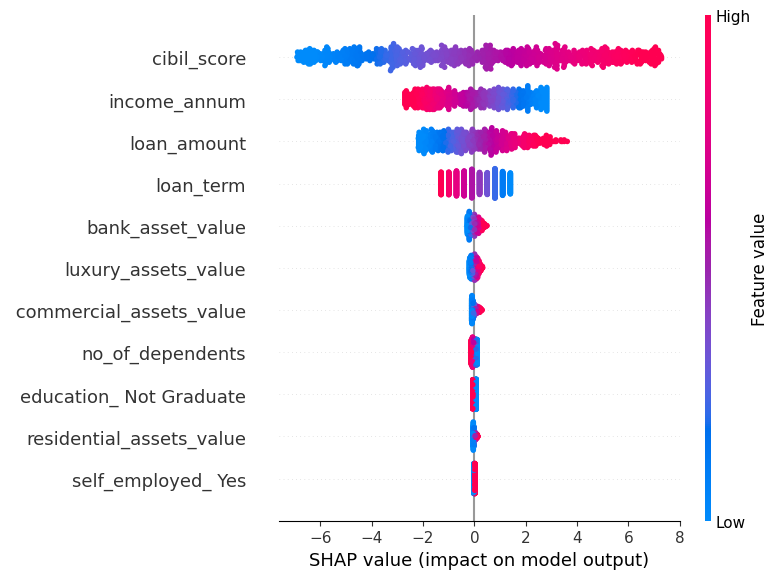

In [51]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)

4.2 Local Explanation

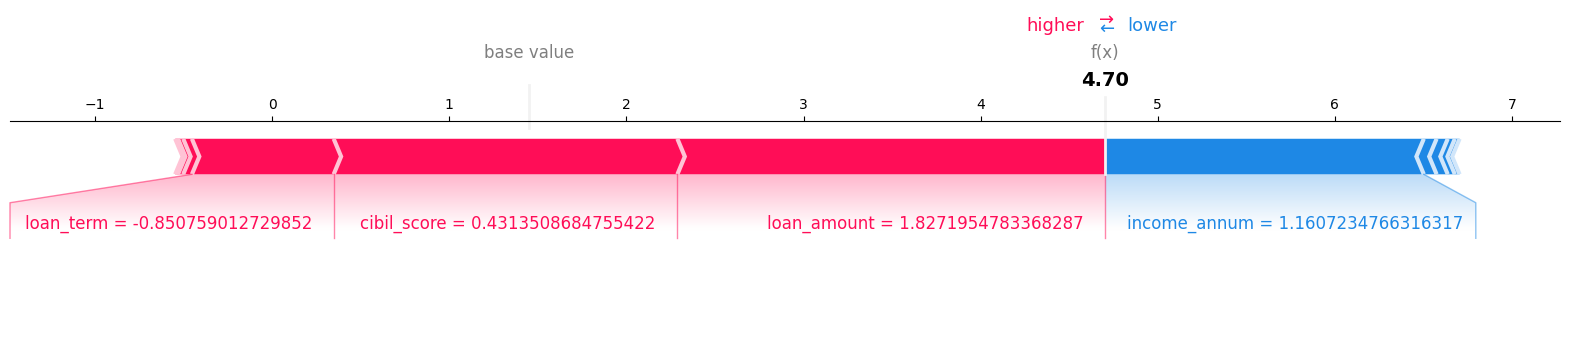

In [52]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test_transformed[0],
    feature_names=feature_names,
    matplotlib=True
)